# Tutorial on processing and analyzing PAX polarization datasets

<font color='red'>Updated: 2024/06/17

<font color='red'>Author: Evan McClintock

## Introduction

To fully characterize the PTF of a fiber optic cable at any point in time (call it $R_C(t)$), one must measure the effect of $R_C$ on *two* linearly independent input SOPs: $V_{1,out} = R_C V_{1,in}$ and $V_{2,out} = R_C V_{2,in}$. The two input states $V_{1,in}$ and $V_{2,in}$ are rapidly alternated in time and transmitted through the DUT. The PAX polarimeter measures $V_{1,out}$ and $V_{2,out}$ as they are alternated in time.

It was observed that the PAX has an extremely poor and inconsistent measurement rate; [this](www.google.com) github repositiory provides a few quick tools (also included here) to characterize variability in the Time Between Samples (TBS) in any PAX dataset. This variability makes it impossible to systematically separate the two output SOPs in time by the number of samples taken. It also seemed highly difficult to synchronize the clock of the waveform generator with that of the PAX (not to mention the variability in the frequency of the generated waveform), so we opted for a programmatic approach to automatically identify the time-alternating behavior and separate the output SOPs for further analysis.

The functions of this github repository are to:
1. Automatically identify the change-points (a.k.a. "switches") between the two SOPs and perform initial processing of the measurement data.
2. Provide tools for subsequent SOP visualization and analysis.

## Overview

Processing a PAX dataset consists of four steps:
1. Read in the raw data
2. Identify the switches (change points)
3. Separate the SOPs and average the data within each segment
4. Calculate drift in the PTF

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib tk
#%matplotlib inline
import pandas as pd
#from datetime import timedelta
import allantools #https://allantools.readthedocs.io/en/latest/functions.html
import os
import scipy.stats as ss
import pickle
#import copy
#import math
#import time
#import seaborn as sns
#import warnings
BOLD_ON = "\033[1m"
BOLD_OFF = "\033[0m"

In [2]:
# Import data analysis code
import importlib
import data_manager
importlib.reload(data_manager)
from data_manager.dataset import Dataset
from data_manager.stationary import StationarySet
from data_manager.switch import SwitchSet
import data_manager.utils.plotting_utils as P
from data_manager.utils.hourly_dividing_utils import Divider
from data_manager.pairs import IOPair

In [3]:
# Directory information
LAB = "/mnt/c/Users/2020n/Documents/Career/Locations/Britton Lab/"   # Path to lab folder
DATA = LAB + "QWDM_Project/H1_Datasets/"   # Path to folder of datasets

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/evanshaped/anaconda3/envs/britton2024envWSL/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


## Example of automatic processing

### Read in raw dataset

Here, we read in, clean, and visualize a raw dataset from the PAX.

Initialize a `SwitchSet` object with the csv file and information on how much data to read.

**Parameters**
- **filename:** ***String***\
  The name of the file to be processed, including the file extension. Example: `filename="/path/to/folder/name_of_file.csv"

- **set_range:** ***Tuple[float, float], optional***\
  Text

- **skip_default_signal_baseline:** ***float, optional***\
  Text

In [6]:
# Read in raw dataset
filename = DATA + 'Whole_setup/24-03-13/PAX_3-13_ARL_Orth_2_1345_desktop.csv'
ds_1345 = SwitchSet(filename, set_range=(0,0.02), skip_default_signal_baseline=25)

Time range: min=25.024, max=839.536


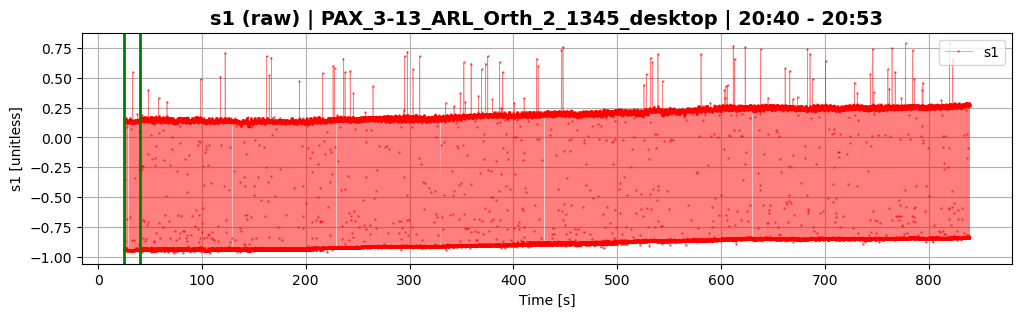

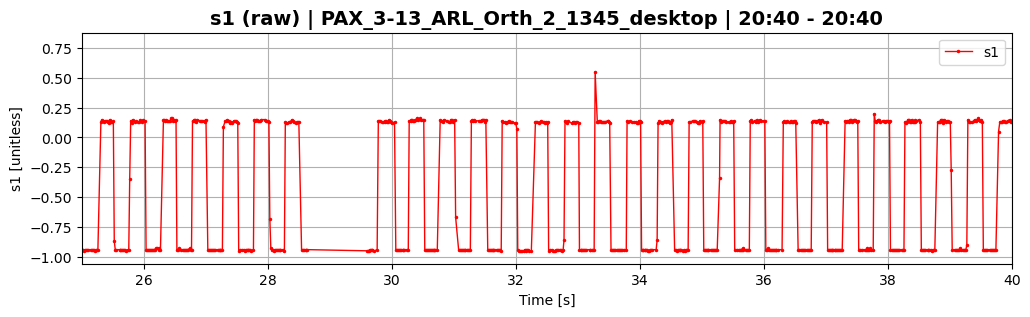

In [7]:
# Plot example section
ds_1345.plot_raw(sample_range=(25,40), birds_eye=True)

### Locate switch times

Using change_point_range_1=(30, 130)
Using change_point_range_2=None
=== performing change point detection ===
cp range: (30.0, 130.0)
using 5127 data entries
skipping 217 points
considering params: ['s1', 's2', 's3']

--- switch param: s1 ---
size of data we are using = (5127,)
computing range... ---> range = (1.06,1.12)
displaying jump_fig for switch parameter = s1



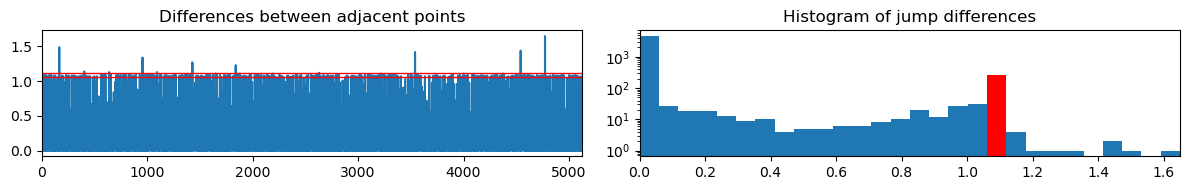



found width of 0.059 for s1
greater than prev width of -1.000 for None
--- end of switch param: s1 ---

--- switch param: s2 ---
size of data we are using = (5127,)
computing range... ---> range = (0.24,0.30)
displaying jump_fig for switch parameter = s2



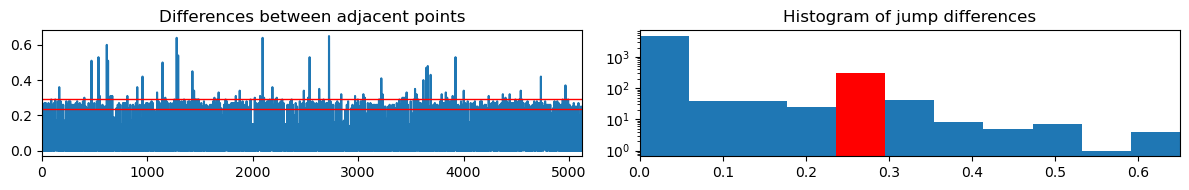



found width of 0.059 for s2
greater than prev width of 0.059 for s1
--- end of switch param: s2 ---

--- switch param: s3 ---
size of data we are using = (5127,)
computing range... ---> range = (0.69,0.75)
displaying jump_fig for switch parameter = s3



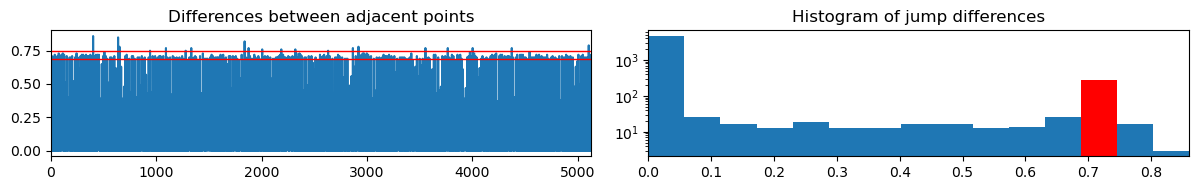



--- end of switch param: s3 ---

---> switch parameter found: s2 <---
finding differences within range = (0.24,0.30)
Jump points detected: 295
out of total: ~399.6

computing offset...


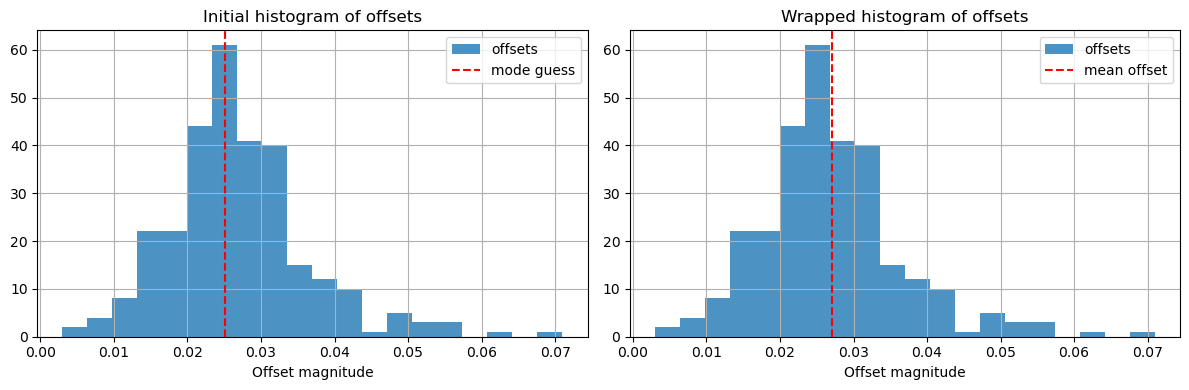



offset = 0.027 seconds
=== end change point detection ===


In [8]:
ds_1345.find_switches(nominal_switch_rate=2, change_point_range_1=(30,130), change_point_range_2=None, n_exclude=3, print_process=True)

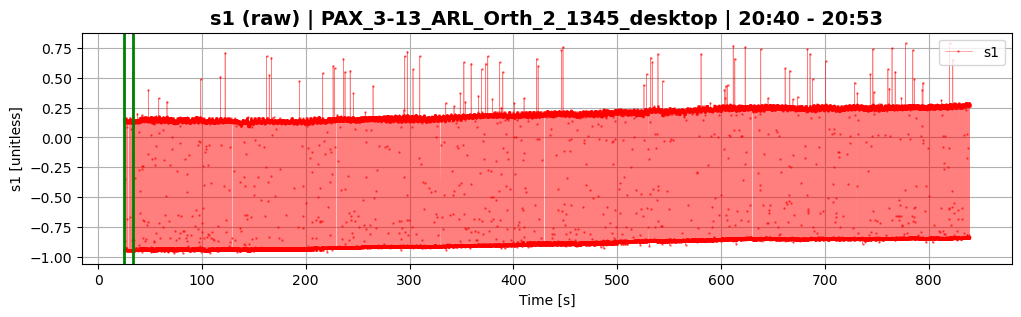

can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


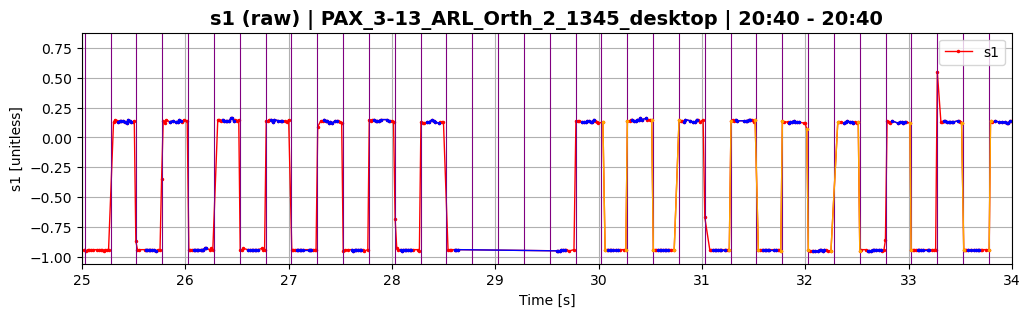

In [9]:
ds_1345.plot_raw(sample_range=(25,34), birds_eye=True, plot_switch=True,plot_jumps=True,plot_valid=True,plot_avg=False)

### Average data

In [10]:
ds_1345.average_data(print_process=False)

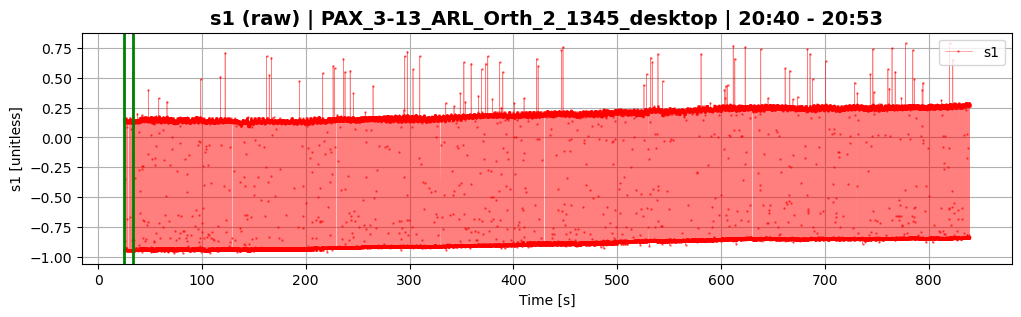

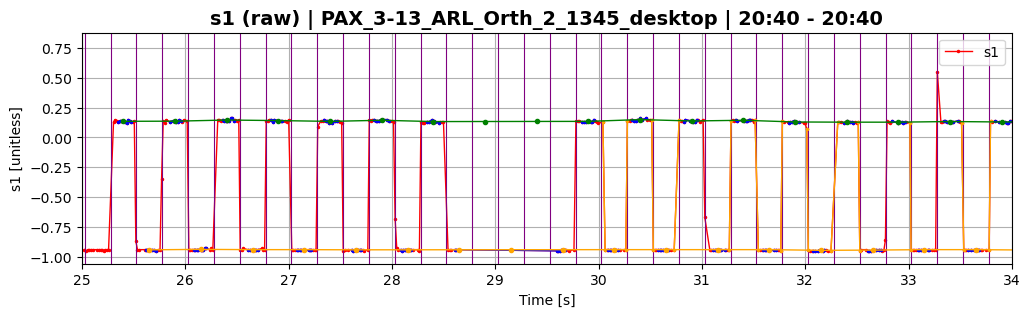

In [11]:
ds_1345.plot_raw(sample_range=(25,34), birds_eye=True, plot_switch=True,plot_jumps=True,plot_valid=True,plot_avg=True)

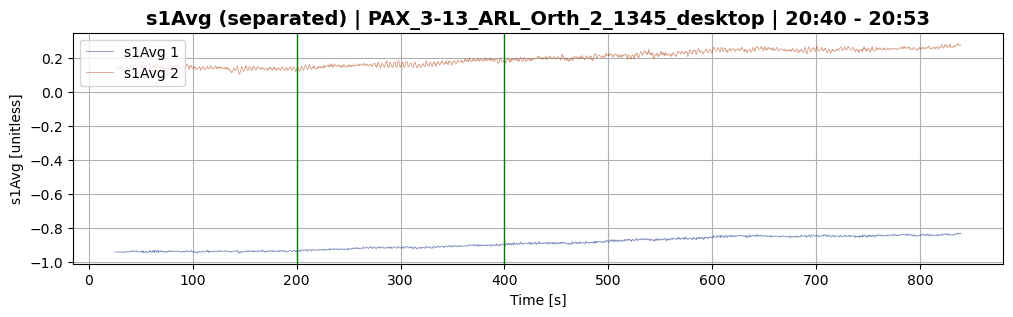

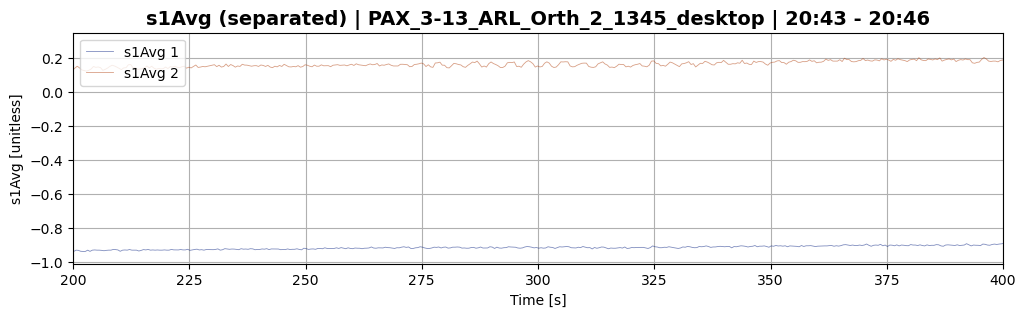

In [12]:
ds_1345.plot_separated(plot_param='s1Avg', sample_range=(200,400))

### Calcuate stokes PTF

In [13]:
reset_times_1345 = ds_1345.calc_stokes_ptf(reference=None, angle_threshold_deg=5, reset_by_rolling=True, rolling_pts=5, print_process=True);

Using "resetting reference SOPs" approach with threshold = 5.0 degrees
Averaging rotAngle using 5 rolling points
Reference matrix was reset 2 times
Reset at time t=283.03
Reset at time t=499.03


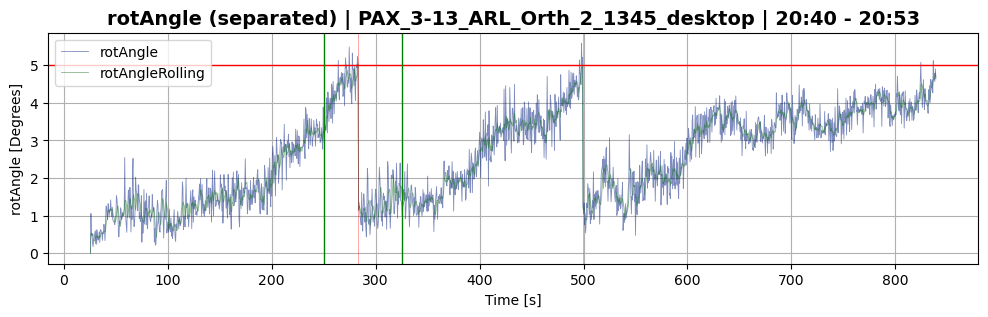

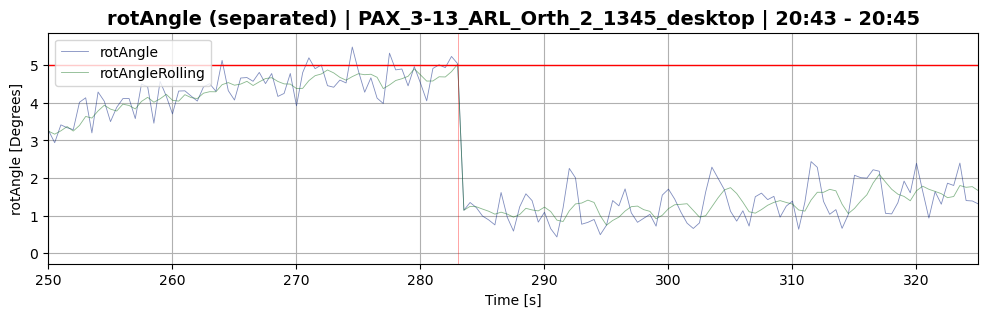

In [14]:
ds_1345.plot_separated(plot_param='rotAngle', sample_range=(250,325))

In [18]:
div = Divider(ds_1345)
params_arr = div.calc_adev_divided()

In [19]:
div.segment_dict

{}

In [17]:
params_arr

[]

In [ ]:
P.plot_adev(params_arr)